In [38]:
%reload_ext autoreload
%autoreload 2

import os
import torch
import numpy as np
from tqdm.auto import tqdm
import pandas as pd
import seaborn as sns
from datasets import Dataset
pd.options.display.float_format = "{:,.2f}".format

In [2]:
def aggregate_results(path, columns=None):
    list_csv = [os.path.join(path, file) for file in os.listdir(path) if file.endswith('.csv')]
    df = pd.DataFrame()

    for csv_file in tqdm(list_csv):
        df_csv = pd.read_csv(
            csv_file,
            usecols=columns,
        )
        df = df.append(df_csv, ignore_index=True)

    return df

In [3]:
def get_method_name(row):
    if row['perturbation'] == 'graph': return f'GP-{row["mp_layers"]}'
    if row['epsilon'] < np.inf: return f'AP-{row["mp_layers"]}'
    if row['mp_layers'] == 0: return 'FP'
    return f'NP-{row["mp_layers"]}'

In [7]:
def privacy_accuracy_plot(path):
    df = aggregate_results(path, columns=['dataset', 'epsilon', 'perturbation', 'test/acc_mean', 'mp_layers'])
    df['method'] = df.apply(get_method_name, axis=1)
    df = df.sort_values(by=['epsilon', 'method'])
    df['epsilon'] = df['epsilon'].apply(lambda eps: df['epsilon'].unique()[:-1] if np.isinf(eps) else eps)
    df = df.explode(column='epsilon')
    df.rename(columns={'test/acc_mean': 'acc'}, inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

In [35]:
df = privacy_accuracy_plot(path='expr/data/')
df

  0%|          | 0/1634 [00:00<?, ?it/s]

,dataset,epsilon,perturbation,mp_layers,acc,method
0,facebook,2.00,aggr,1,78.14,AP-1
1,lastfm,2.00,aggr,1,73.40,AP-1
2,amz-comp,2.00,aggr,1,67.29,AP-1
3,wiki,2.00,aggr,1,63.63,AP-1
4,reddit,2.00,aggr,1,62.46,AP-1
...,...,...,...,...,...,...
2751,reddit,80.00,aggr,2,98.24,NP-2
2752,reddit,85.00,aggr,2,98.24,NP-2
2753,reddit,90.00,aggr,2,98.24,NP-2
2754,reddit,95.00,aggr,2,98.24,NP-2


In [40]:
list(Dataset.supported_datasets)

['facebook',
 'reddit',
 'fb-illinois',
 'lastfm',
 'amz-comp',
 'amz-photo',
 'fb-penn',
 'fb-texas',
 'co-ph',
 'co-cs',
 'wiki',
 'fb-indiana',
 'fb-harvard',
 'pubmed',
 'cora',
 'citeseer',
 'github']

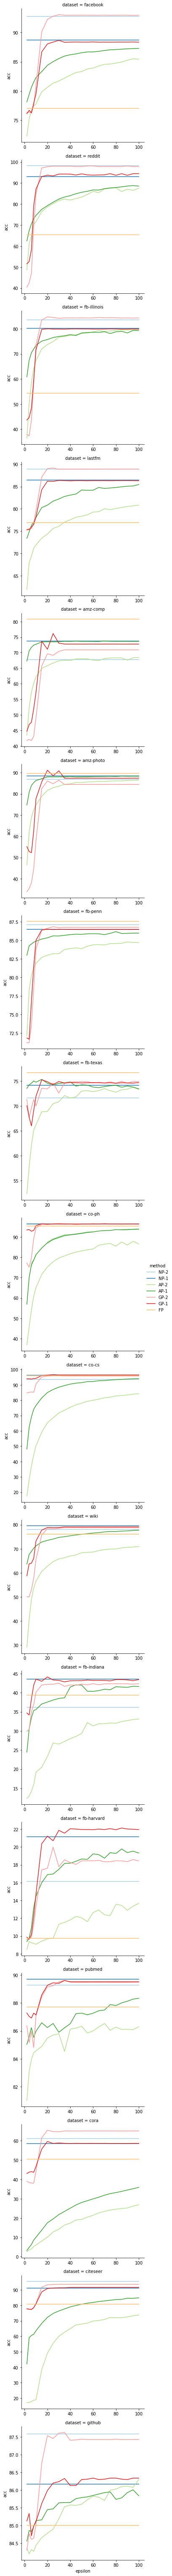

In [41]:
sns.relplot(kind='line', data=df, x='epsilon', y='acc', hue='method', row='dataset', 
            facet_kws={'sharey': False, 'sharex': False},
            row_order=list(Dataset.supported_datasets),
            palette=sns.color_palette("Paired")[:7], hue_order=['NP-2', 'NP-1', 'AP-2', 'AP-1', 'GP-2', 'GP-1', 'FP'])

In [25]:
list_csv = [os.path.join('expr/data/', file) for file in os.listdir('expr/data/') if file.endswith('.csv')]

for csv_file in tqdm(list_csv):
    df = pd.read_csv(csv_file)
    if (df['dataset'] == 'fb-indiana').all():
        os.remove(csv_file)

  0%|          | 0/1634 [00:00<?, ?it/s]